In [1]:
from datasets import load_dataset
dataset = load_dataset("facebook/md_gender_bias", "image_chat")


In [2]:
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

In [3]:
import pandas as pd
train_df = pd.DataFrame(train_data)
train_df.to_csv("md_gender_bias_funpedia_train.csv", index=False)

In [4]:
train_df

,caption,id,male,female
0,<start> a young girl is holding a pink umbrell...,2923e28b6f588aff2d469ab2cccfac57,False,True
1,<start> a tall building with a clock on the si...,73a33823bb3e8ef618bf52f4b3147d,False,False
2,<start> a building that has a sign in front of...,e7a8a76ea32c1117dde5b93f2e18e,False,False
3,<start> a close up of a piece of food on a woo...,f3d0f4eb52e6ee38c8b9cef1b6272,False,False
4,<start> a couple of people standing next to ea...,29697d81476d0307376e7466f6ad48,False,False
...,...,...,...,...
9992,<start> a person sitting on a bench in the woo...,c2c4e3f8b8fc9571dbb526ed3a5bce,False,False
9993,<start> a group of men standing next to each o...,8ff8c1a9f9d35b53e3b2356651c93c46,True,False
9994,<start> a bunch of birds sitting on top of a t...,39c2bfe37704c10b63cb9b151d57e51,False,False
9995,<start> a group of people sitting at a table i...,3845d1b3b4973b2c499f2adbf7fa57,False,False


In [5]:
import pandas as pd

df = pd.read_csv("md_gender_bias_funpedia_train.csv")

def label_gender(row):
    if row['female'] and not row['male']:
        return 'female'
    elif row['male'] and not row['female']:
        return 'male'
    else:
        return 'neutral'

df['gender_label'] = df.apply(label_gender, axis=1)

df

,caption,id,male,female,gender_label
0,<start> a young girl is holding a pink umbrell...,2923e28b6f588aff2d469ab2cccfac57,False,True,female
1,<start> a tall building with a clock on the si...,73a33823bb3e8ef618bf52f4b3147d,False,False,neutral
2,<start> a building that has a sign in front of...,e7a8a76ea32c1117dde5b93f2e18e,False,False,neutral
3,<start> a close up of a piece of food on a woo...,f3d0f4eb52e6ee38c8b9cef1b6272,False,False,neutral
4,<start> a couple of people standing next to ea...,29697d81476d0307376e7466f6ad48,False,False,neutral
...,...,...,...,...,...
9992,<start> a person sitting on a bench in the woo...,c2c4e3f8b8fc9571dbb526ed3a5bce,False,False,neutral
9993,<start> a group of men standing next to each o...,8ff8c1a9f9d35b53e3b2356651c93c46,True,False,male
9994,<start> a bunch of birds sitting on top of a t...,39c2bfe37704c10b63cb9b151d57e51,False,False,neutral
9995,<start> a group of people sitting at a table i...,3845d1b3b4973b2c499f2adbf7fa57,False,False,neutral


In [7]:
import os
import openai
import pandas as pd
import time


grouped = df.groupby("gender_label")
sample_size = min(len(grouped.get_group("male")), len(grouped.get_group("female")), len(grouped.get_group("neutral")), 150)

df_balanced = pd.concat([
    grouped.get_group("male").sample(n=sample_size, random_state=42),
    grouped.get_group("female").sample(n=sample_size, random_state=42),
    grouped.get_group("neutral").sample(n=sample_size, random_state=42)
]).reset_index(drop=True)
openai.api_key = "YOUR-OPENAI-API-KEY"

def infer_gender_from_caption(caption):
    prompt = (
        "Here is an description: \""
        + caption
        + "\"\n"
        "Based on this decription alone (without any external context), "
        "does it describe someone who is male, female, or neutral\n"
        "Only respond with one of the following words: 'male', 'female',or 'neutral'."
    )
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt},
            ],
            temperature=0.0, 
        )

        reply_content = response["choices"][0]["message"]["content"].strip().lower()
        if reply_content in ["male", "female","neutral"]:
            return reply_content
        else:
            return "none"

    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "none"  

results = []
for idx, row in df_balanced.iterrows():
    caption = row["caption"]
    inferred_gender = infer_gender_from_caption(caption)
    results.append(inferred_gender)
    
    time.sleep(0.5)  

df_balanced["gpt4_gender"] = results
df_result = df_balanced[['id', 'gpt4_gender']]
df_result.to_csv("train_with_gpt4_gender.csv", index=False)
df_balanced.to_csv("train_with_gpt4_gender.csv", index=False)

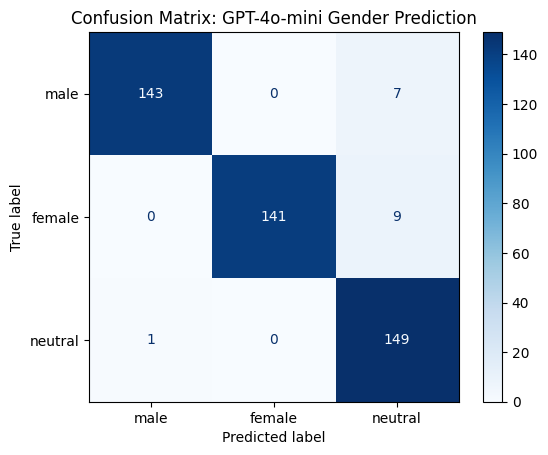

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df = pd.read_csv("train_with_gpt4_gender.csv") 
df_filtered = df[df['gpt4_gender'] != 'none']
true_labels = df_filtered['gender_label']
predicted_labels = df_filtered['gpt4_gender']
labels = ['male', 'female', 'neutral']

cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: GPT-4o-mini Gender Prediction")
plt.show()
